In [1]:
import pandas as pd

In [2]:
folder_root = "/Users/admin/Desktop/myvenv/benchmark/results/"

In [19]:
clustering = ["baseline"] # "data clustering" missing for now, future: also model clustering
distribution = ["iid","shard"]
n_clients = ["10","20"]

In [20]:
len(n_clients)

2

In [21]:
# Initiate empty dataframe
final_df = pd.DataFrame(columns=["Round","Partition ID","Accuracy","Loss","Distribution Type","Number of Clients","Clustering Type"])

for clust in clustering:
    for dist in distribution:
        for number in n_clients:
            print("test")
            df = pd.read_csv(folder_root+clust+"/"+dist+"_"+number+"_clients/client_accuracies.csv")

            # Create a list for distribution type
            distribution_type = [dist for d in range(len(df))]
            # Create a list for number of clients
            clients_amount = [number for n in range(len(df))]
            # Create a list for clustering type
            clustering_type = [clust for c in range(len(df))]

            # Add lists to dataframe as further columns
            df['Distribution Type'] = distribution_type
            df['Number of Clients'] = clients_amount
            df['Clustering Type'] = clustering_type

            # Append dataframe to final dataframe
            final_df = pd.concat([final_df,df])




test
test
test
test


/var/folders/1j/4t8zm9tj47vdc3j4ntfc4xtw0000gn/T/ipykernel_84324/3333487682.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df,df])


In [23]:
final_df.to_csv("baseline_results.csv",index=False)

In [4]:
# For each unique combination of "distribution type, number of clients and clustering type", calculate the average accuracy and loss per round and plot it


,Round,Partition ID,Accuracy,Loss
0,1,2,0.968333,4.042044
1,1,3,0.964167,5.023772
2,1,7,0.951667,5.203059
3,1,6,0.958333,5.037689
4,1,0,0.965000,4.051360
...,...,...,...,...
95,10,5,0.992500,1.178569
96,10,6,0.985000,2.238166
97,10,9,0.990833,1.707170
98,10,1,0.985833,2.356956


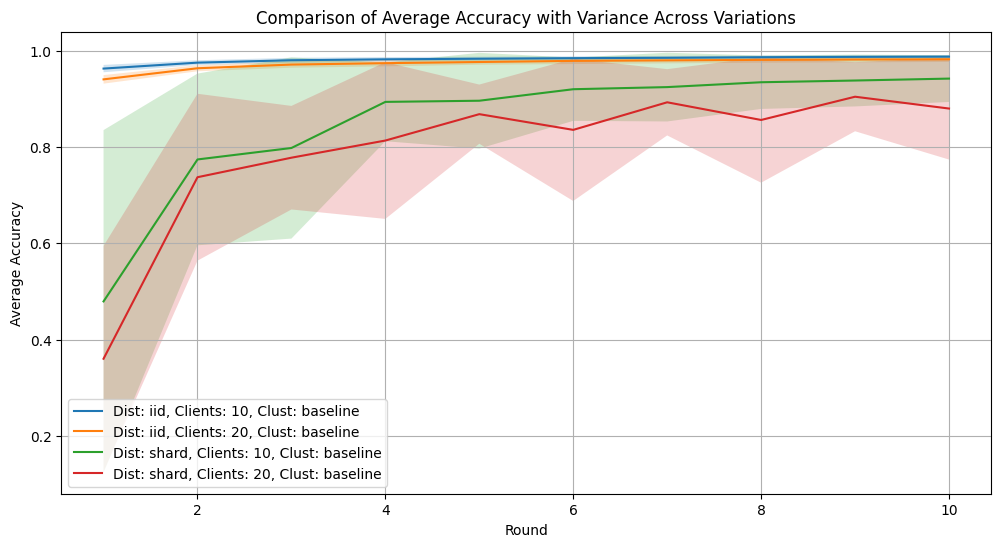

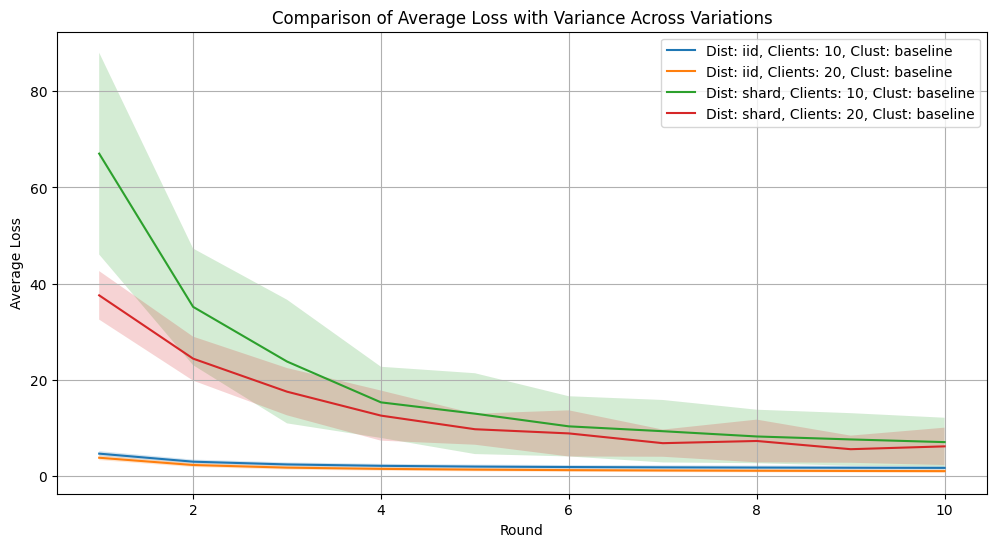

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming your dataframe is already created as final_df
# Group by the necessary columns and round, then calculate the mean and variance
grouped_df = final_df.groupby(
    ["Round", "Distribution Type", "Number of Clients", "Clustering Type"]
).agg(
    {"Accuracy": ["mean", "var"], "Loss": ["mean", "var"]}
).reset_index()

# Flatten the multi-index columns
grouped_df.columns = ['Round', 'Distribution Type', 'Number of Clients', 'Clustering Type', 'Accuracy_Mean', 'Accuracy_Var', 'Loss_Mean', 'Loss_Var']

# Plot accuracy with variance for all combinations
plt.figure(figsize=(12, 6))

for (dist_type, n_clients, clust_type), group in grouped_df.groupby(
    ["Distribution Type", "Number of Clients", "Clustering Type"]
):
    label = f"Dist: {dist_type}, Clients: {n_clients}, Clust: {clust_type}"
    
    # Plot the mean accuracy
    plt.plot(group["Round"], group["Accuracy_Mean"], label=label)
    
    # Plot the variance as a shaded area
    plt.fill_between(
        group["Round"],
        group["Accuracy_Mean"] - np.sqrt(group["Accuracy_Var"]),
        group["Accuracy_Mean"] + np.sqrt(group["Accuracy_Var"]),
        alpha=0.2
    )

plt.title("Comparison of Average Accuracy with Variance Across Variations")
plt.xlabel("Round")
plt.ylabel("Average Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

# Plot loss with variance for all combinations
plt.figure(figsize=(12, 6))

for (dist_type, n_clients, clust_type), group in grouped_df.groupby(
    ["Distribution Type", "Number of Clients", "Clustering Type"]
):
    label = f"Dist: {dist_type}, Clients: {n_clients}, Clust: {clust_type}"
    
    # Plot the mean loss
    plt.plot(group["Round"], group["Loss_Mean"], label=label)
    
    # Plot the variance as a shaded area
    plt.fill_between(
        group["Round"],
        group["Loss_Mean"] - np.sqrt(group["Loss_Var"]),
        group["Loss_Mean"] + np.sqrt(group["Loss_Var"]),
        alpha=0.2
    )

plt.title("Comparison of Average Loss with Variance Across Variations")
plt.xlabel("Round")
plt.ylabel("Average Loss")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [1]:
import os
import tensorflow as tf
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, DistributionPartitioner, ExponentialPartitioner, InnerDirichletPartitioner, LinearPartitioner, NaturalIdPartitioner, PathologicalPartitioner, ShardPartitioner, SizePartitioner, SquarePartitioner
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

fds = None

transforms = ToTensor()
def apply_transforms(batch):
    batch["img"] = [transforms(img) for img in batch["img"]]
    return batch

def load_data(data_name, n_partitioner, chosen_partitioner, saving=False):
    # Download and partition dataset
    # Only initialize `FederatedDataset` once
    # Possible partitioners: https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html

    # Make directories for storing datasets
    if not os.path.exists("data"):
        os.mkdir("data")

    if not os.path.exists(f"data/{data_name}"):
        os.mkdir(f"data/{data_name}")

    if not os.path.exists(f"data/{data_name}/{n_partitioner}_partitions"):
        os.mkdir(f"data/{data_name}/{n_partitioner}_partitions")

    # Load data from flower
    global fds
    if fds is None:
        fds = FederatedDataset(
            dataset=data_name,
            partitioners={"train": chosen_partitioner},
            seed=42
        )
    
    if saving:
        print("Saving data as csv files")
        # Save each partition to a csv file
        for partition in tqdm(range(n_partitioner)):
            part = fds.load_partition(partition)
            part.set_format("numpy")
            df = pd.DataFrame(part)
            #df.to_csv(f"data/{data_name}/{n_partitioner}_partitions/{partition}.csv", index=False)
            x = part
    
    else:
        partitions_train = []
        partitions_test = []
        for partition in tqdm(range(n_partitioner)):
            part = fds.load_partition(partition)
            part.set_format("numpy")
            # Divide data on each node: 80% train, 20% test
            part = partition.train_test_split(test_size=0.2)
            x_train, y_train = partition["train"]["img"] / 255.0, partition["train"]["label"]
            x_test, y_test = partition["test"]["img"] / 255.0, partition["test"]["label"]
            list_of_partitions.append(part)

    return df,x

/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_name = "mnist"
n_partitioner = 10
chosen_partitioner = IidPartitioner(10)

In [2]:
import os
import tensorflow as tf
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, DistributionPartitioner, ExponentialPartitioner, InnerDirichletPartitioner, LinearPartitioner, NaturalIdPartitioner, PathologicalPartitioner, ShardPartitioner, SizePartitioner, SquarePartitioner
from tqdm import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

fds = None

def load_data(data_name, n_partitioner, chosen_partitioner, saving=False):
    # Download and partition dataset
    # Only initialize `FederatedDataset` once
    # Possible partitioners: https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html

    transforms = ToTensor()
    def apply_transforms(batch):
        batch["img"] = [transforms(img) for img in batch["image"]]
        return batch

    # Make directories for storing datasets
    if not os.path.exists("data"):
        os.mkdir("data")

    if not os.path.exists(f"data/{data_name}"):
        os.mkdir(f"data/{data_name}")

    if not os.path.exists(f"data/{data_name}/{n_partitioner}_partitions"):
        os.mkdir(f"data/{data_name}/{n_partitioner}_partitions")

    # Load data from flower
    global fds
    if fds is None:
        fds = FederatedDataset(
            dataset=data_name,
            partitioners={"train": chosen_partitioner},
            seed=42
        )

    if saving:
        print("Saving data as csv files")
        # Save each partition to a csv file
        for partition in tqdm(range(n_partitioner)):
            part = fds.load_partition(partition)
            part.set_format("numpy")
            df = pd.DataFrame(part)
            #df.to_csv(f"data/{data_name}/{n_partitioner}_partitions/{partition}.csv", index=False)
            x = part

    else:
        partitions_train = []
        partitions_test = []
        for partition in tqdm(range(n_partitioner)):
            part = fds.load_partition(partition)
            part.set_format("numpy")
            part_torch = part.with_transform(apply_transforms)
            #part = part.train_test_split(test_size=0.2)
            partition_train_test = part_torch.train_test_split(test_size=0.2, seed=42)
            partition_train = partition_train_test["train"]
            partition_test = partition_train_test["test"]
            partitions_train.append(partition_train)
            partitions_test.append(partition_test)

    return partitions_train, partitions_test

/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/admin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, DistributionPartitioner, ExponentialPartitioner, InnerDirichletPartitioner, LinearPartitioner, NaturalIdPartitioner, PathologicalPartitioner, ShardPartitioner, SizePartitioner, SquarePartitioner

fds = None

def load_data(partition_id: int, chosen_partitioner, test_size=0.2, saving=False):
    """Load data."""
    # Only initialize `FederatedDataset` once
    global fds
    if fds is None:
        partitioner = chosen_partitioner
        fds = FederatedDataset(
            dataset="mnist",
            partitioners={"train": partitioner},
        )
    partition = fds.load_partition(partition_id)
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size, seed=42)
    pytorch_transforms = Compose(
        [ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32, shuffle=True)
    testloader = DataLoader(partition_train_test["test"], batch_size=32)
    return trainloader, testloader

In [ ]:
fds = None


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, DistributionPartitioner, ExponentialPartitioner, InnerDirichletPartitioner, LinearPartitioner, NaturalIdPartitioner, PathologicalPartitioner, ShardPartitioner, SizePartitioner, SquarePartitioner

fds = None

def load_data(partition_id: int, num_partitions: int):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global fds
    if fds is None:
        fds = FederatedDataset(
            dataset="mnist",
            partitioners={"train": IidPartitioner(num_partitions),
            },
            trust_remote_code=True
        )
    
    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch
    
    partition = fds.load_partition(partition_id)
    partition = partition.rename_column("image", "img")
    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # pytorch_transforms = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # For CIFAR10

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(partition_train_test["train"], batch_size=32)
    testloader = DataLoader(partition_train_test["test"], batch_size=32)

    return trainloader, testloader

/Users/admin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
trainloader, testloader = load_data(0, 10)

In [3]:
trainloader

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner, DistributionPartitioner, ExponentialPartitioner, InnerDirichletPartitioner, LinearPartitioner, NaturalIdPartitioner, PathologicalPartitioner, ShardPartitioner, SizePartitioner, SquarePartitioner

fds = None

def load_data(num_partitions: int, partitioner):
    """Load partition MNIST data."""
    # Only initialize `FederatedDataset` once
    global fds
    if fds is None:
        fds = FederatedDataset(
            dataset="mnist",
            partitioners={"train": partitioner,
            },
            trust_remote_code=True
        )
    
    def apply_transforms(batch):
        """Apply transforms to the partition from FederatedDataset."""
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch
    
    trainloaders = []
    testloaders = []

    for partition_id in range(num_partitions):
        partition = fds.load_partition(partition_id)
        partition = partition.rename_column("image", "img")
        # Divide data on each node: 80% train, 20% test
        partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
        pytorch_transforms = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
        # pytorch_transforms = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # For CIFAR10

        partition_train_test = partition_train_test.with_transform(apply_transforms)
        trainloader = DataLoader(partition_train_test["train"], batch_size=32)
        testloader = DataLoader(partition_train_test["test"], batch_size=32)
        testloaders.append(testloader)
        trainloaders.append(trainloader)

    return trainloaders, testloaders

/Users/admin/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/admin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
fds = None
trainloaders, testloaders = load_data(10, IidPartitioner(10))
x = trainloaders[1].dataset[1]["img"].numpy().flatten()
fds = None
trainloaders, testloaders = load_data(10, IidPartitioner(10))
y = trainloaders[1].dataset[1]["img"].numpy().flatten()
# Check if both numpy arrays are equal
np.array_equal(x, y)

True

In [5]:
import numpy as np


True

In [2]:
x = trainloaders[1].dataset[1]["img"].numpy().flatten()

NameError: name 'trainloaders' is not defined

In [3]:
x = trainloaders[1].dataset[1]["img"].numpy().flatten()

In [5]:
y = trainloaders[1].dataset[1]["img"].numpy().flatten()

In [6]:
import numpy as np

In [7]:
# Check if both numpy arrays are equal
np.array_equal(x, y)

True

In [143]:
sum(x == y)

784

In [121]:
for batch in trainloaders[0]:
    images = batch["img"]
    labels = batch["label"]

In [124]:
batch

{'img': tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],
 
 
         [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],


In [106]:
labels

tensor([1, 1, 5, 5, 1, 7, 4, 6, 9, 2, 0, 3, 3, 5, 0, 5, 0, 3, 4, 7, 2, 1, 0, 7,
        4, 0, 3, 2, 6, 5, 5, 9])

In [90]:
images = trainloaders[0].dataset["img"]
#labels = batch["label"]

TypeError: 'DataLoader' object is not subscriptable

In [89]:
trainloaders[0].dataset.data

MemoryMappedTable
img: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
label: int64
----
img: [
  -- is_valid: all not null
  -- child 0 type: binary
[89504E470D0A1A0A0000000D494844520000001C0000001C0800000000576680480000010049444154789C636018CC80594848A8AE63BDD4B2FFDFEB19181818586012726C563602C10C0C0C0C4F26057EBE789081818181112A67B8971FCAFA97F495E1D9FB9BC8260ADDFEFBF7EFDFBFC7B67DFF88C5BE8039D97FFF9EE566D09E85CD357C8CB3FE46A10A31C1599FFE7F64486162C005B8F7FD75C329C9A0FCF1E1821C465CB2811FFEFE2D97C425ABBBEBEFDF69D2B8640562FFFCDD8DDBE29F7F7F3A40992CA8327A21A62C0CD70E61D3A43EE5E9DFBF7F7F6DC322255174F7EFDFBF7F4FFA614A893B5DFDFBF7EFDF6381988124B4FAF6DFBF7FFF1E0EE0C490325FF3E8EFDFBF7FBFB472A38AB330303030040632305CDFFCB7E7033657521F000045175E806B4C003B0000000049454E44AE426082,89504E470D0A1A0A0000000D494844520000001C0000001C080000000057668048000000FF49444154789C63601878603CFFEF7C231C7206EFFEFCF9F316BB9CD9E3BF7FDEBFFC63C98629C565F3E0CFDF3FA742FEFCAD8208302149C

In [78]:
y = trainloaders[0].dataset["img"]

In [71]:
y

In [79]:
x==y

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [31]:
x

In [21]:
y

In [30]:
x = testloaders[0]

In [5]:
trainloaders[0].dataset["img"][0].numpy()


array([[[-0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296],
        [-0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296],
        [-0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, -0.42421296, -0.42421296, -0.42421296,
         -0.42421296, 

In [61]:
trainloader.dataset.data

MemoryMappedTable
img: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
label: int64
----
img: [
  -- is_valid: all not null
  -- child 0 type: binary
[89504E470D0A1A0A0000000D494844520000001C0000001C0800000000576680480000010049444154789C636018CC80594848A8AE63BDD4B2FFDFEB19181818586012726C563602C10C0C0C0C4F26057EBE789081818181112A67B8971FCAFA97F495E1D9FB9BC8260ADDFEFBF7EFDFBFC7B67DFF88C5BE8039D97FFF9EE566D09E85CD357C8CB3FE46A10A31C1599FFE7F64486162C005B8F7FD75C329C9A0FCF1E1821C465CB2811FFEFE2D97C425ABBBEBEFDF69D2B8640562FFFCDD8DDBE29F7F7F3A40992CA8327A21A62C0CD70E61D3A43EE5E9DFBF7F7F6DC322255174F7EFDFBF7F4FFA614A893B5DFDFBF7EFDF6381988124B4FAF6DFBF7FFF1E0EE0C490325FF3E8EFDFBF7FBFB472A38AB330303030040632305CDFFCB7E7033657521F000045175E806B4C003B0000000049454E44AE426082,89504E470D0A1A0A0000000D494844520000001C0000001C080000000057668048000000FF49444154789C63601878603CFFEF7C231C7206EFFEFCF9F316BB9CD9E3BF7FDEBFFC63C98629C565F3E0CFDF3FA742FEFCAD8208302149C

In [74]:
for x in trainloader:
    print(x)
    break

{'img': tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242

In [76]:
part_torch

Dataset({
    features: ['image', 'label'],
    num_rows: 6000
})

In [77]:
dataloader = DataLoader(part_torch, batch_size=64)

In [104]:
dataloader.data

6000

In [9]:
from flwr.client import NumPyClient, ClientApp
from flwr.common import Context

from clustering_project.task import (
    Net,
    DEVICE,
    load_data,
    get_weights,
    set_weights,
    train,
    test,
)


# Define Flower Client and client_fn
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader, local_epochs):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader
        self.local_epochs = local_epochs

    def fit(self, parameters, config):
        set_weights(self.net, parameters)
        results = train(
            self.net,
            self.trainloader,
            self.valloader,
            self.local_epochs,
            DEVICE,
        )
        return get_weights(self.net), len(self.trainloader.dataset), results

    def evaluate(self, parameters, config):
        set_weights(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return loss, len(self.valloader.dataset), {"accuracy": accuracy}

In [88]:
client = FlowerClient(net = Net, trainloader=trainloader, valloader=testloader,local_epochs=2)

In [93]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
for batch in trainloader:
    images = batch["image"]
    labels = batch["label"]
    # optimizer.zero_grad()
    # criterion(net(images.to(DEVICE)), labels.to(DEVICE)).backward()
    # optimizer.step()

TypeError: list indices must be integers or slices, not str

In [10]:
train(Net, trainloader, testloader, 2)

TypeError: parameters() missing 1 required positional argument: 'self'

In [100]:
if isinstance(DEVICE, str):
    device = torch.device(DEVICE)
    
    # Step 2: Move model to the specified device
    net.to(device)

In [101]:
device = torch.device(DEVICE)

In [102]:
device

device(type='cpu')